In [56]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

In [57]:
digits = load_digits(n_class=6)
X, y = digits.data, digits.target
n_samples, n_features = X.shape
print(X[0])
print(n_samples, n_features)

[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]
1083 64


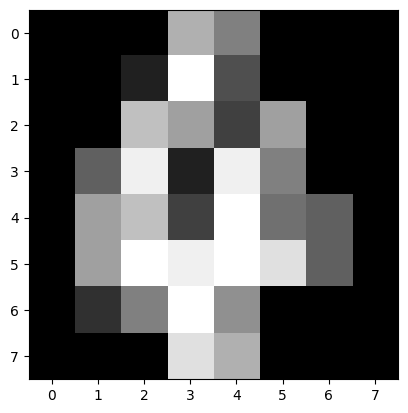

In [78]:
# reshape X[0] to a 2D array
img = np.reshape(X[0], (8, 8))

# plot the image
plt.imshow(img, cmap='gray')
plt.show()


In [59]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=124)

# basic_classifier = svm.SVC(gamma=0.001)
basic_classifier = KNeighborsClassifier(n_neighbors=3)
basic_classifier.fit(x_train, y_train)
predicted = basic_classifier.predict(x_test)

# print("Classification report for classifier %s:\n%s\n")
# print(classification_report(y_test, predicted))

print("Accuracy score: ", accuracy_score(y_test, predicted))

Accuracy score:  0.996309963099631


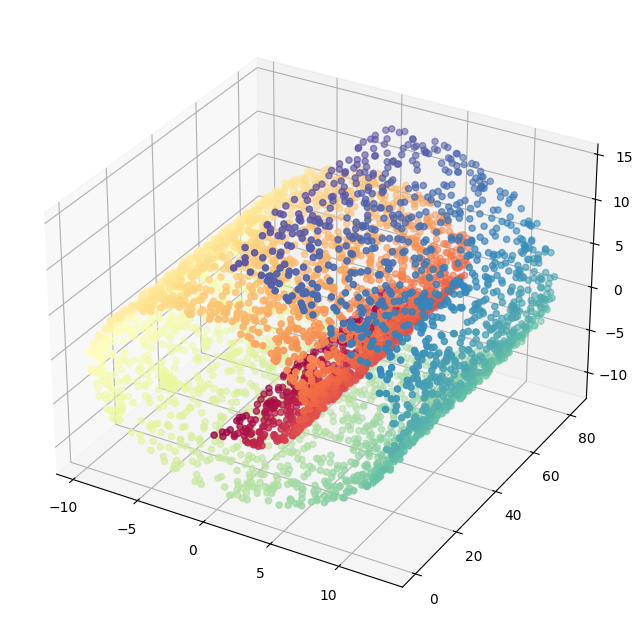

In [60]:
def make_swiss_roll(n_samples=100, noise=0.0, random_state=None):
    #Generate a swiss roll dataset.
    t = 1.5 * np.pi * (1 + 2 * np.random.rand(1, n_samples))
    x = t * np.cos(t)
    y = 83 * np.random.rand(1, n_samples)
    z = t * np.sin(t)
    X = np.concatenate((x, y, z))
    X += noise * np.random.randn(3, n_samples)
    X = X.T
    t = np.squeeze(t)
    return X, t

X_swiss, Y_swiss = make_swiss_roll(n_samples = 5000, noise=0.1, random_state=42)

plt.figure(figsize=(8, 8))
ax = plt.subplot(projection='3d')
ax.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2], c=Y_swiss, cmap=plt.cm.Spectral)
plt.show()

# Neighborhood Preserving Embedding (NPE)
![alt text](img/NPE_algorithm.png "Algorithm")


## Step 1: KNN from scratch

In [61]:
X = x_train
y = y_train
# X = X_swiss
# y = Y_swiss

In [79]:
from sklearn.neighbors import NearestNeighbors

# Create a NearestNeighbors model
k = 11  # You can change this value to the number of neighbors you want
nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto', n_jobs=-1).fit(X)
k = k - 1 #This becase the first neighbor is the point itself

# Query for nearest neighbors
Q_distances = []
Q_indices = []
for i in range(len(X)):
    distance, index = nbrs.kneighbors([X[i]])
    # print("distance: ", distance[0])
    # print("index: ", index[0])
    Q_distances.append(distance[0][1:])
    Q_indices.append(index[0][1:])

# distances: Array of distances to the k nearest neighbors
# indices: Array of indices of the k nearest neighbors in x_train

# print(Q_distances)
# print(Q_indices[0])


## Step 2: Compute the weight matrix W

Each point of the dataset is reconstructed as a linear weighted sum of its neighbors. Since only neighbors participate in reconstruction it is local. Reconstruction is achieved by linear coefficients of weights, hence linear. That is why this method is named as locally linear embedding.\
The weights of points Pi and Pj are independent from each other.\
Rotation, rescalings, and translations of a points and its neighbors are don't affect the local W matrix of the point.\
It is important to note that while solving for W if the number of neighbors is greater than the original dimension D some of the weight coefficients might be zero leading to multiple solutions. This issue can be handled by adding a regularization to the least squares problems penalizing the large weights.

Theconstraint k j=1wij=1meansthattheweightsof linearreconstructionsumtooneforeverypoint.Notethat thefactthatsomeweightsmaybenegativecausestheproblemofexplosionofsomeweightsbecauseverylargepositiveandnegativeweightscancanceleachothertohavea totalsumofone.However,thisproblemdoesnotoccur because,aswewillsee,thesolutiontothisoptimization problemhasaclosedform;thus,weightsdonotexplode.

$$\min \sum_{i}\Vert {\bf x}_{i}-\sum_{j}W_{ij}{\bf x}_{j}\Vert^{2}$$
with contraints $\sum_{j}W_{ij}=1,j=1,2, \ldots, m$

<!-- ![alt text](img/formula_3.png) -->

In [63]:
tol = 1e-5



n = len(X)
# W = np.zeros((n, n))
W = []
k_1 = np.ones((k))
I = np.ones((k, 1))

for i in range(n):
    xi = X[i]
    C = []
    for j in range(k):
        xj = X[Q_indices[i][j]]
        C_aux = []
        for m in range(k):
            xm = X[Q_indices[i][m]]
            C_jk =(xi - xj).T @ (xi - xm)
            C_aux.append(C_jk)
        C.append(C_aux)
    C = np.array(C)
    # print(C.shape)
    C = C + tol * np.eye(*C.shape) # Regularization for C
    # w_bis = np.linalg.solve(C, k_1) # Calculate weights for x_i
    # w_bis = w / w.sum() # Normalize weights; sum(w)=1
    w = np.linalg.inv(C) @ k_1
    w = w / (k_1.T @ np.linalg.inv(C) @ k_1)

    # Create an 1 x n array that will contain a 0 if xj is not a 
    # neighbour of xi, otherwise it will cointain the weight of x_j
    w_real = np.zeros((1, n))
    np.put(w_real, Q_indices[i], w)
    # np.put(w_real, Q_indices[i], w_bis)
    W.append(list(w_real[0]))

W = np.array(W)
print(W.shape)

(812, 812)


## Step 3: Computing the projections

In [64]:
import scipy.sparse.linalg as linalg
# X = X_swiss

d = 9
alpha = 1e-5
A = []

I = np.eye(n)

M = (I - W).T @ (I - W)


# eigvalues, eigvectors = linalg.eigs(M, k=d, which='LM')
eigvalues, eigvectors = np.linalg.eig(M)

# z = eigvectors

        # sort eigenvectors
# pairs = list(zip(eigvalues, eigvectors.T)) # Pair each eigenvalue with its corresponding eigenvector
# pairs.sort(key=lambda x: x[0], reverse=False) # Sort the pairs in ascending order of the eigenvalue
# sorted_eigvalues, sorted_eigvectors = zip(*pairs) # Unpack the sorted pairs
# z = np.array(sorted_eigvectors).T # Convert the sorted eigenvectors back to a 2D array

# Sort the eigenvalues and eigenvectors in ascending order
index_ = np.argsort(np.abs(eigvalues))[1:d+1]
z = eigvectors[:, index_]
print(z.shape)

I = np.eye(X.shape[1])
for i in range(d):
    ai = (X.T @ X) + (alpha * I)
    ai = np.linalg.inv(ai)
    print(ai.shape)
    ai = ai @ X.T @ z[:, i]
    A.append(ai)


A = np.array(A).T
print(A.shape)

(812, 9)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 9)


### Transforming the data

In [65]:
A.shape

(64, 9)

In [74]:
x_train_transformed = []
x_test_transformed = []
for i in range(X.shape[0]):
    x_train_transformed.append( A.T @ X[i])
for i in range(len(x_test)):
    x_test_transformed.append( A.T @ x_test[i])
# print(x_train_transformed)
x_train_transformed = np.array(x_train_transformed)
x_test_transformed = np.array(x_test_transformed)

## Evaluation
pca
mds
isomap
lle
kernel pca
diffusion maps
sketch map
t-sne
umap
(autoencoders)

In [81]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import MDS, Isomap, LocallyLinearEmbedding, TSNE, SpectralEmbedding #is this the same as diffusion maps?
# sketch map manca

pca = PCA(n_components=d)
kernel_pca = KernelPCA(n_components=d, kernel='rbf', gamma=0.1)
mds = MDS(n_components=d)
isomap = Isomap(n_components=d)
lle = LocallyLinearEmbedding(n_components=d)
tsne = TSNE(n_components=d)
spectral_embedding = SpectralEmbedding(n_components=d)

x_train_transformed_pca = pca.fit_transform(X)
x_train_transformed_kernel_pca = kernel_pca.fit_transform(X)
x_train_transformed_mds = mds.fit_transform(X)
x_train_transformed_isomap = isomap.fit_transform(X)
x_train_transformed_lle = lle.fit_transform(X)
x_train_transformed_tsne = tsne.fit_transform(X)
x_train_transformed_spectral_embedding = spectral_embedding.fit_transform(X)


/home/thomas/anaconda3/envs/unsup/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/thomas/anaconda3/envs/unsup/lib/python3.10/site-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/thomas/anaconda3/envs/unsup/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [85]:
basic_classifier = KNeighborsClassifier(n_neighbors=3)

list_of_transformations = [x_train_transformed, x_train_transformed_pca, x_train_transformed_kernel_pca, x_train_transformed_mds, x_train_transformed_isomap, x_train_transformed_lle, x_train_transformed_tsne, x_train_transformed_spectral_embedding]
list_of_names = ["NPE", "PCA", "Kernel PCA", "MDS", "Isomap", "LLE", "t-SNE", "Spectral Embedding"]

i=0
for x_trans in list_of_transformations:
    basic_classifier = KNeighborsClassifier(n_neighbors=3)
    basic_classifier.fit(x_trans, y_train)
    predicted = basic_classifier.predict(x_trans)
    print("Accuracy score for ", list_of_names[i], ": ", round(accuracy_score(y_train, predicted), 2))
    i+=1






Accuracy score for  NPE :  0.99
Accuracy score for  PCA :  0.89
Accuracy score for  Kernel PCA :  0.59
Accuracy score for  MDS :  0.93
Accuracy score for  Isomap :  0.99
Accuracy score for  LLE :  0.98
Accuracy score for  t-SNE :  1.0
Accuracy score for  Spectral Embedding :  0.96


In [87]:



# basic_classifier = svm.SVC(gamma=0.001)
basic_classifier = KNeighborsClassifier(n_neighbors=3)
basic_classifier.fit(x_train_transformed, y_train)
predicted = basic_classifier.predict(x_test_transformed)

# print("Classification report for classifier %s:\n%s\n")
# print(classification_report(y_test, predicted))

print("Accuracy score: ", accuracy_score(y_test, predicted))

Accuracy score:  0.974169741697417


## Step 4: Visualizing the results

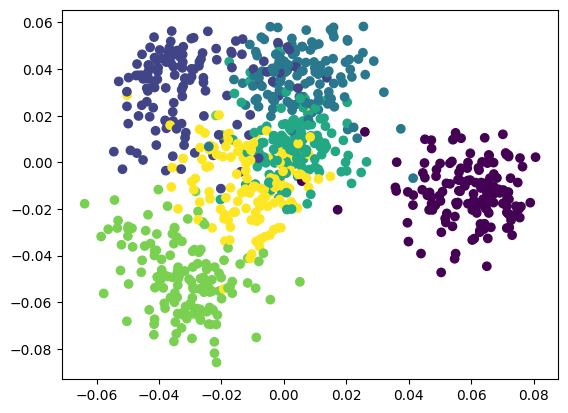

In [68]:


plt.scatter(x_train_transformed[:, 0], x_train_transformed[:, 1], c=y)
plt.show()


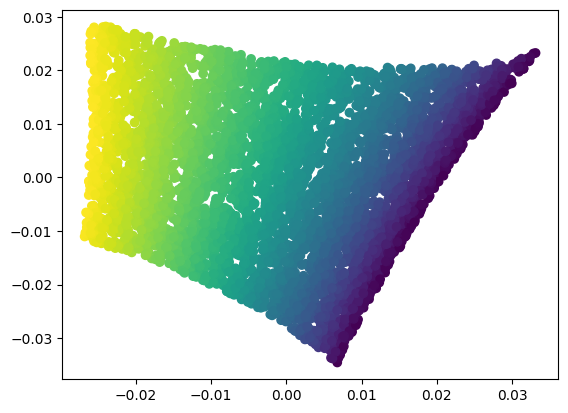

In [69]:
from sklearn.manifold import locally_linear_embedding

X_lle, err = locally_linear_embedding(X_swiss, n_neighbors=12, n_components=2)
plt.scatter(X_lle[:, 0], X_lle[:, 1], c=Y_swiss)
plt.show()


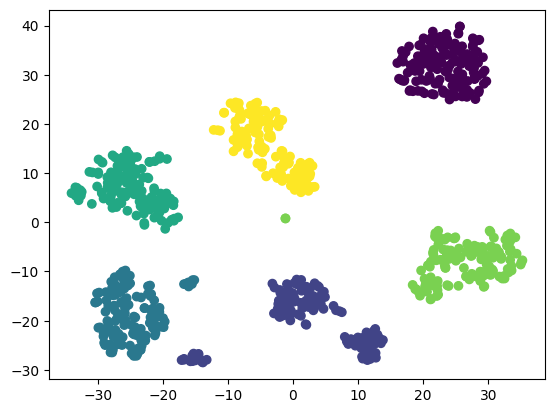

In [70]:
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2).fit_transform(X)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y)
plt.show()

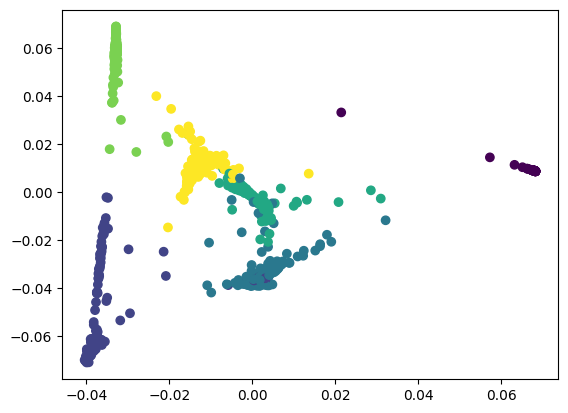

In [71]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=d, n_neighbors=k)
lle_data = lle.fit_transform(X)


plt.scatter(lle_data[:, 0], lle_data[:, 1], c=y_train)
plt.show()


[5.336924479002934e-17, 1.2577368922855241e-08, 2.8852503251537177e-06, 3.9168319134666046e-06, 1.483166139871425e-05, 2.6432973199950186e-05, 8.098138580644574e-05, 0.0002478928927177285, 0.00038261347308358193, 0.0004636267083731307, 0.0005617122346365519, 0.0006490289258128288, 0.0009553059814434845, 0.001063691687749234, 0.0013098664951440736, 0.0016963920540143068, 0.0017624832378264578, 0.0019080285560364352, 0.002277233357697585, 0.0025804029512232415, 0.002812022382727536, 0.003398654669997946, 0.0034763786496748122, 0.003942231062957168, 0.004101063080231693, 0.004256501504693037, 0.0043512556468272194, 0.004731899026932088, 0.0050474182385816194, 0.005735292880744451, 0.006178742063787087, 0.006274510418178372, 0.006775934504891943, 0.007487583793533895, 0.007521199295489862, 0.007962123476615604, 0.008729034036841237, 0.009087274902989358, 0.009314355276670525, 0.009645556731781791, 0.0107673380192001, 0.011107194898040828, 0.011140951197098197, 0.011631163186363433, 0.01191

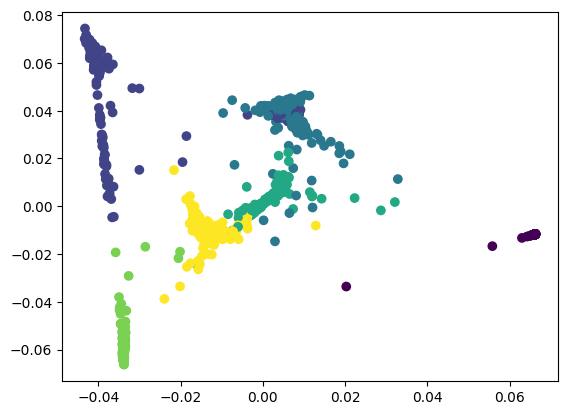

In [72]:
# ## THIS IS A TEST

## LLE algorithm

d = 2

I = np.eye(n)
M = (I - W).T @ (I - W)

eigvalues, eigvectors = np.linalg.eig(M)
print(sorted(np.abs(eigvalues)))
index_ = np.argsort(np.abs(eigvalues))[1:d+1]
lle_data = eigvectors[:, index_]

plt.scatter(lle_data[:, 0], lle_data[:, 1], c=y_train)
plt.show()